In [10]:
#import libraries and functions
import numpy as np
import scipy.linalg as la
import random
import matplotlib.pyplot as plt

In [11]:
#Pauli matrices
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

In [12]:
#setup inital hamiltonian
N = 2 #number of qubits
msize = 2**N
Jz = 0.1 #ising interaction strength !!! Not used for 1-qubit
mu_x = 0.3 #transverse magnetic field strength
hinit = np.zeros((msize, msize), dtype=np.complex128)
hinit+=-Jz*np.kron(sz,sz)
hinit+=-mu_x*np.kron(sx,np.eye(2))
hinit+=-mu_x*np.kron(np.eye(2),sx)

In [13]:
#setup final hamiltonian; assuming lambda is in front of the x field
hfin = np.zeros((msize, msize), dtype=np.complex128)
hfin+=-Jz*np.kron(sz,sz)

In [14]:
eigvals_i, eigvecs_i = la.eig(hinit) # eigenvalues of the initial state
eigvals_f, eigvecs_f = la.eig(hfin) # eigenvalues of the final

In [16]:
beta = 4.0 #inverse temperature of systems
#calculate the initial partition function
zval_i = 0
for ival in eigvals_i:
    zval_i = zval_i +np.real(np.exp(-beta*ival))

#calculate the final partition function
zval_f = 0
for ival in eigvals_f:
    zval_f = zval_f +np.real(np.exp(-beta*ival))

In [17]:
# free energy difference to compare
print(zval_i,zval_f,-np.log(zval_f)+np.log(zval_i))

13.644115004072912 4.32428948735382 1.1490604469249759


In [18]:
#define simulation variables
tau = 10 #total trajectory time to evolve lambda from 0 to 1
dtau = 1.0 #time-step for trajectory
num_steps = int(tau/dtau)
T = 10 #total number of trajectories
dt =  dtau #timestep for Trotter approximation: setting equal to dtau means one trotter-step per time-step in evolution
lambda_protocol = np.linspace(1.0, 0,num_steps)
print(lambda_protocol)
dldt = (lambda_protocol[1]-lambda_protocol[0])/dtau # d(lambda)/d(tau)
print(dldt) 
mu_x = 0.3 #transverse magnetic field strength
hbar = 0.658211951 #in eV-fs

[1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ]
-0.11111111111111116


In [33]:
work = [] #append values of work that we get out

for i in range(T):
    #choose a random number
    asv = random.uniform(0, 1)

    #pick an eigenstate to propogate with the correct probability
    select = 0
    scum = 0
    for ival in range(msize):
       scum = scum+np.real(np.exp(-beta*eigvals_i[ival]))/zval_i
       if scum > asv: select = ival
       if scum > asv: break

    curstate =  eigvecs_i[:,select]

    #iterate through our protocol ##NEED TO ADD HBAR
    v = curstate
    o = np.kron(np.eye(2), sz) + np.kron(sz,np.eye(2))
    work_i = 0
    for j in range(num_steps):
        hnew = hinit-j*mu_x*(-np.kron(sx,np.eye(2))+-np.kron(np.eye(2),sx))*(1./(num_steps-1)) ##check what comes out here
        w = la.expm(-1j*dt*hnew/hbar) @ v
        v = w
        m = v.conjugate().T @ o @ v #measure the magnetization; check with Lindsay
        work_i += -mu_x*m*dldt*dtau #check with Lindsay

    work.append(work_i)

In [34]:
print(work)

[(6.633015412442503e-34+0j), (-6.53276984013037e-17+0j), (-6.53276984013037e-17+0j), (-6.53276984013037e-17+0j), (-6.53276984013037e-17+0j), (-6.53276984013037e-17+0j), (-6.53276984013037e-17+0j), (6.633015412442503e-34+0j), (-6.53276984013037e-17+0j), (-6.53276984013037e-17+0j)]


In [36]:
print(hnew)

[[-1.00000000e-01+0.j -5.55111512e-17+0.j -5.55111512e-17+0.j
   0.00000000e+00+0.j]
 [-5.55111512e-17+0.j  1.00000000e-01+0.j  0.00000000e+00+0.j
  -5.55111512e-17+0.j]
 [-5.55111512e-17+0.j  0.00000000e+00+0.j  1.00000000e-01+0.j
  -5.55111512e-17+0.j]
 [ 0.00000000e+00+0.j -5.55111512e-17+0.j -5.55111512e-17+0.j
  -1.00000000e-01+0.j]]


In [35]:
print(hfin)
print(hinit)

[[-0.1+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.1+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0.1+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.1+0.j]]
[[-0.1+0.j -0.3+0.j -0.3+0.j  0. +0.j]
 [-0.3+0.j  0.1+0.j  0. +0.j -0.3+0.j]
 [-0.3+0.j  0. +0.j  0.1+0.j -0.3+0.j]
 [ 0. +0.j -0.3+0.j -0.3+0.j -0.1+0.j]]


In [22]:
#save data to file
fname = 'mu_x_{}_beta_{}_hist.csv'.format(mu_x, beta)
f = open(fname, 'w')
f.write("N: "+ str(N) + '\n')
f.write("mu_x: "+ str(mu_x) + '\n')
f.write("beta: "+ str(beta) + '\n')
f.write("T: "+ str(T) + '\n')
f.write("tau: "+ str(tau) + '\n')
f.write("dtau: "+ str(dtau) + '\n')

np.savetxt(f, work, delimiter=',')

/Users/katieklymko/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:849: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/katieklymko/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/Users/katieklymko/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:1959: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


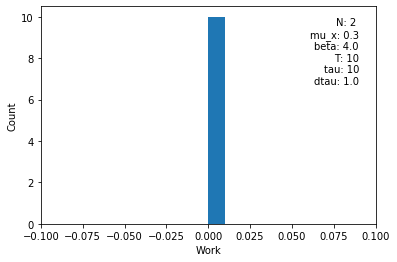

In [23]:
#plot data and save figure
nbins = 100
plt.xlabel('Work')
plt.ylabel('Count')
data_str = f"N: {N} "+"\n"+f"mu_x: {mu_x}"+"\n"+f"beta: {beta}"+"\n"+f"T: {T}"+"\n"+f"tau: {tau}"+"\n"+f"dtau: {dtau}" 
ax = plt.gca()
ax.text(0.95, 0.95, data_str,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
plt.hist(work, bins = nbins)

#May or may not want to limit x-axis
plt.xlim(-0.1,0.1)
fname = 'mu_x_{}_beta_{}_hist.png'.format(mu_x, beta)
plt.savefig(fname)
plt.show()